#pip install vaderSentiment

In [1]:
pip install vaderSentiment


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.7 MB/s eta 0:00:00


#import the libraries

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer , WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpara
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel , TfidfModel , ldamodel
from sklearn.feature_extraction.text import TfidfTransformer ,TfidfVectorizer , CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.metrics import accuracy_score , classification_report

# set plot options

In [4]:
plt.rcParams['figure.figsize'] = (12,8)
default_plot_colour ="#00bfbf"

#read data set

In [5]:
data = pd.read_csv("/content/drive/MyDrive/fake_news_data.csv")
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


# data informations

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


#count of article classifiation

Text(0.5, 1.0, ' count of article classifiation')

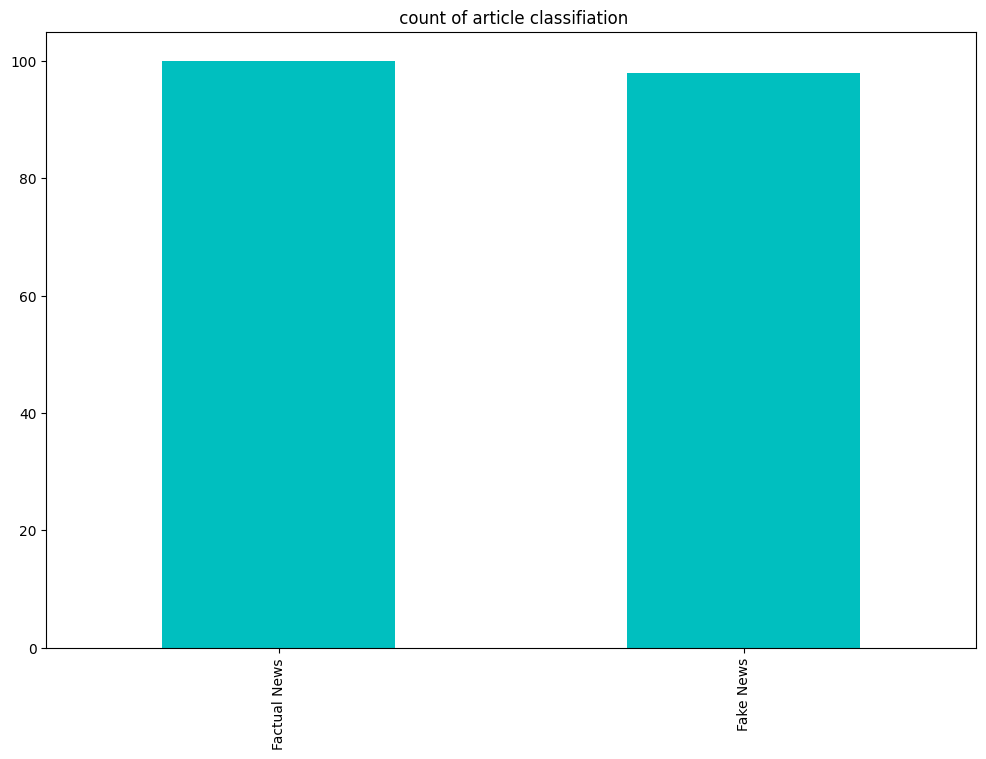

In [7]:
data['fake_or_factual'].value_counts().plot(kind='bar' , color=default_plot_colour)

plt.title(" count of article classifiation")

# POS Tagging

In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
fake_news = data[data['fake_or_factual']=='Fake News']

fact_news = data[data['fake_or_factual']=='Factual News']

In [10]:
fake_spacy_docs = list(nlp.pipe(fake_news['text']))

fact_spacy_docs = list(nlp.pipe(fact_news['text']))

In [11]:
pip install spacy

In [12]:
def extract_token_tags(doc :spacy.tokens.doc.Doc):
  return[(i.text , i, i.pos_)for i in doc]

In [13]:
fake_tagsdf = []

columns = ["token" ,"ner_tag" , "pos_tag"]

In [14]:
for ix , doc in enumerate(fake_spacy_docs):
  tags = extract_token_tags(doc)
  tags = pd.DataFrame(tags)
  tags.columns = columns

  fake_tagsdf.append(tags)

In [15]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [16]:
fact_tagsdf=[]

for ix , doc in enumerate(fact_spacy_docs):
  tags = extract_token_tags(doc)
  tags = pd.DataFrame(tags)
  tags.columns = columns

  fact_tagsdf.append(tags)


In [17]:
fact_tagsdf = pd.concat(fact_tagsdf)

In [18]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,There,PRON
1,are,are,VERB
2,two,two,NUM
3,small,small,ADJ
4,problems,problems,NOUN


In [19]:
#fake_tagsdf['pos_tag'] = fake_tagsdf['ner.tag'].str.split('-', expand=True)

In [20]:
pos_counts_fake = fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name="counts").sort_values(by ="counts" ,ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
28,",",PUNCT,1908
7446,the,DET,1834
39,.,PUNCT,1531
5759,of,ADP,922
2661,and,CCONJ,875
2446,a,DET,804
0,,SPACE,795
7523,to,PART,767
4915,in,ADP,667
5094,is,AUX,419


In [21]:
pos_counts_fact = fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name="counts").sort_values(by ="counts" ,ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6169,the,DET,1903
15,",",PUNCT,1698
22,.,PUNCT,1381
4733,of,ADP,884
1905,a,DET,789
2100,and,CCONJ,757
4015,in,ADP,672
6230,to,PART,660
4761,on,ADP,482
5586,said,VERB,452


In [22]:
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2597
VERB     1814
PROPN    1657
ADJ       876
ADV       412
NUM       221
PRON       99
ADP        88
AUX        58
SCONJ      54
Name: token, dtype: int64

In [23]:
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2182
VERB     1535
PROPN    1387
ADJ       753
ADV       271
NUM       203
PRON       81
ADP        70
AUX        44
SCONJ      39
Name: token, dtype: int64

In [24]:
pos_counts_fake[pos_counts_fake.pos_tag=="NOUN"][:15]

,token,pos_tag,counts
5969,people,NOUN,77
7959,women,NOUN,55
6204,president,NOUN,53
7511,time,NOUN,52
8011,year,NOUN,44
3134,campaign,NOUN,44
4577,government,NOUN,41
5208,law,NOUN,40
7344,t,NOUN,40
8013,years,NOUN,40


In [25]:
pos_counts_fact[pos_counts_fact.pos_tag=="NOUN"][:15]

,token,pos_tag,counts
3748,government,NOUN,71
6639,year,NOUN,64
5927,state,NOUN,58
2373,bill,NOUN,55
1982,administration,NOUN,51
3289,election,NOUN,48
5084,president,NOUN,47
4804,order,NOUN,45
4937,people,NOUN,45
2509,campaign,NOUN,42


# Named Entities

In [26]:
pos_counts_fake = fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name="counts").sort_values(by ="counts" ,ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
28,",",PUNCT,1908
7446,the,DET,1834
39,.,PUNCT,1531
5759,of,ADP,922
2661,and,CCONJ,875
2446,a,DET,804
0,,SPACE,795
7523,to,PART,767
4915,in,ADP,667
5094,is,AUX,419


In [27]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != " "].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by="counts", ascending=False)

In [28]:
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != " "].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by="counts", ascending=False)

In [29]:
ner_palette={
    "ORG":sns.color_palette("Set2").as_hex()[0],
    "GPE":sns.color_palette("Set2").as_hex()[1],
    "NORP":sns.color_palette("Set2").as_hex()[2],
    "PERSON":sns.color_palette("Set2").as_hex()[3],
    "DATA":sns.color_palette("Set2").as_hex()[4],
    "CARDINAL":sns.color_palette("Set2").as_hex()[5],
    "RERCENT":sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'most common named entities in fake news')]

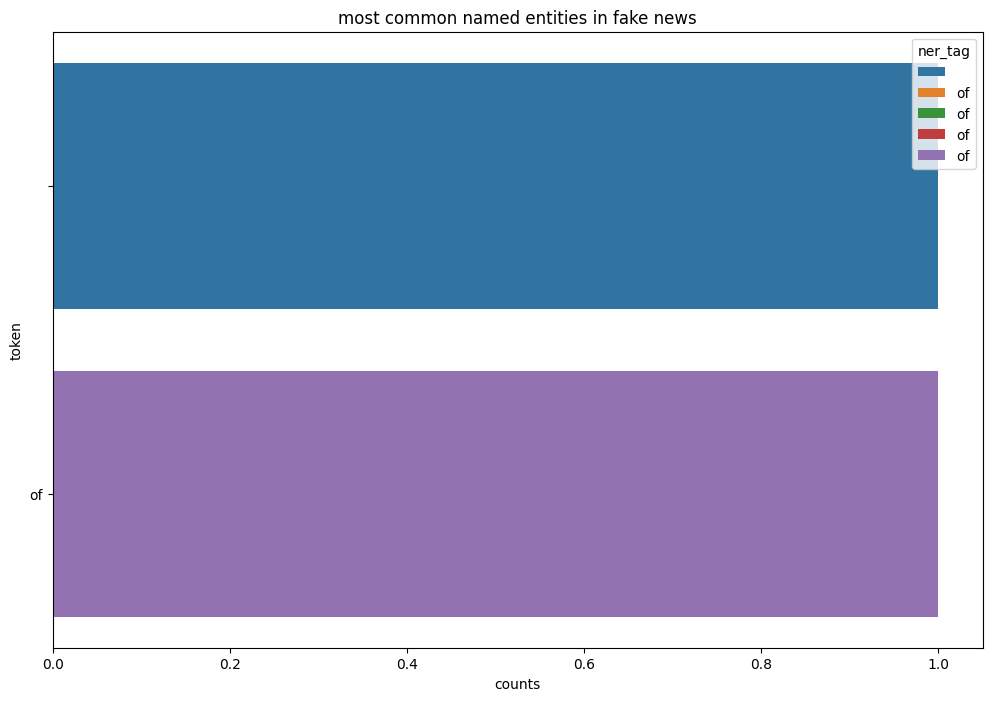

In [30]:
sns.barplot(x = 'counts' ,y = 'token' , hue ='ner_tag', data=top_entities_fake[:5] ,orient ='h',dodge=False).set(title="most common named entities in fake news")

[Text(0.5, 1.0, 'most common named entities in fake news')]

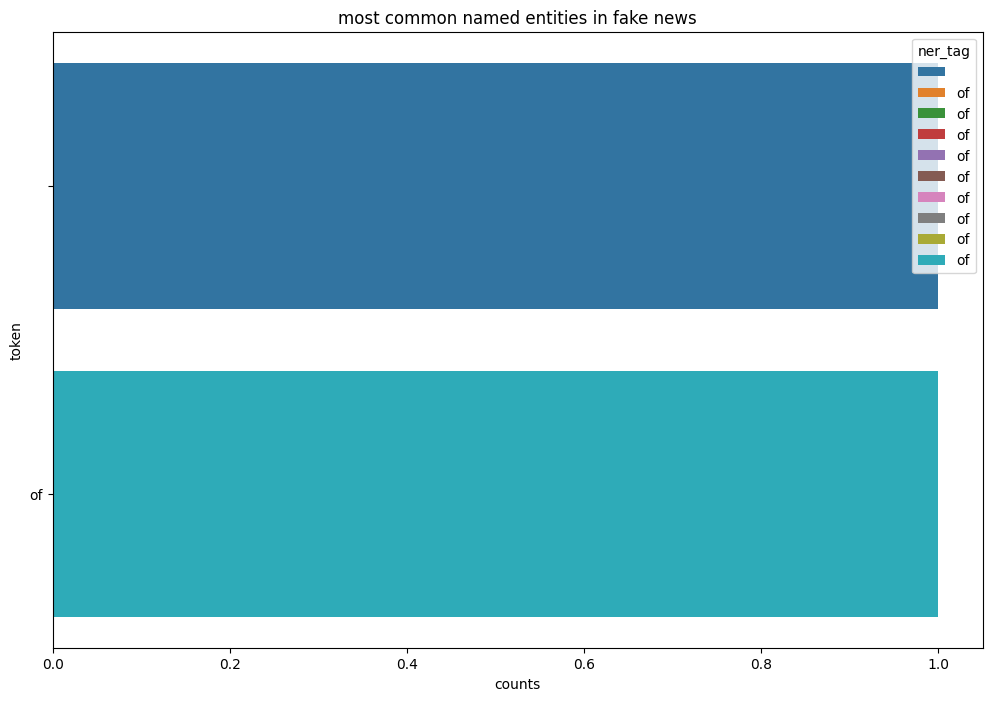

In [31]:
ner_palette = sns.color_palette()
sns.barplot(x = 'counts' ,y = 'token' , hue ='ner_tag',palette=ner_palette, data=top_entities_fact[:10] ,orient ='h',dodge=False).set(title="most common named entities in fake news")

[Text(0.5, 1.0, 'most common named entities in fake news')]

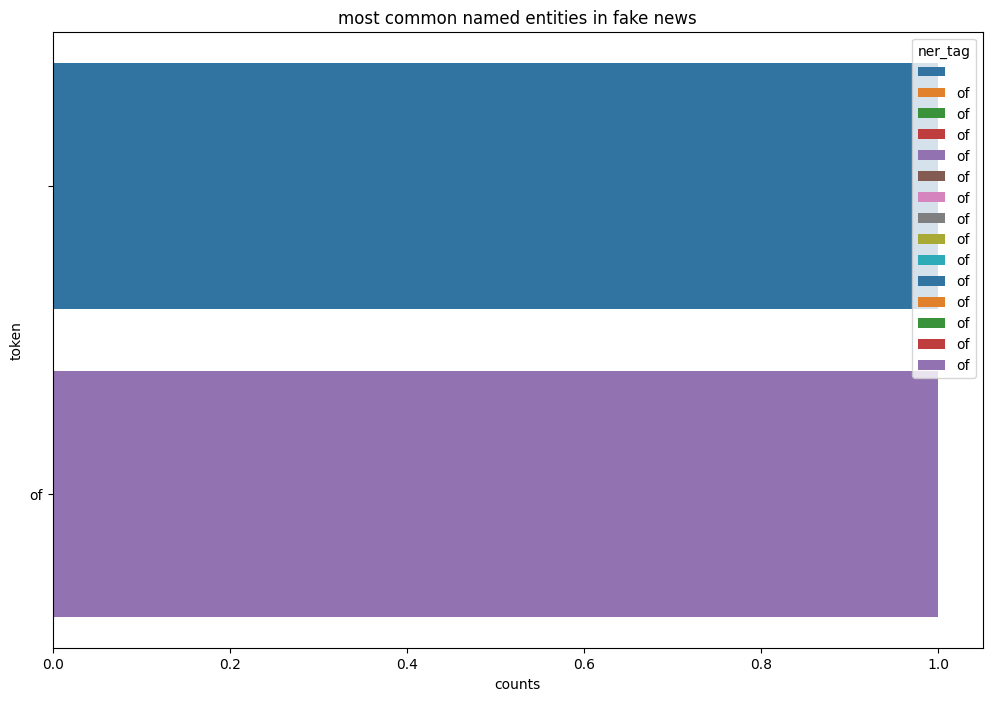

In [32]:
ner_palette=sns.color_palette()
sns.barplot(x = 'counts' ,y = 'token' , hue ='ner_tag',palette=ner_palette, data=top_entities_fact[:15] ,orient ='h',dodge=False).set(title="most common named entities in fake news")



In [ ]:
#sns.barplot(x ='counts',y ='token',hue='ner_tag',palette=ner_palette,data=top_entities_fake[:10] ,orient ='h',dodge=False).set(title="most common named entities in fake news")

# Text Pre_processing

In [33]:
data.head(10)

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News
5,Maxine Waters Makes Teens Chant ‘Impeach 45′ a...,Shame on Teen Vogue! Maxine Waters was a guest...,"Dec 10, 2017",Fake News
6,Jay Carney Let It Slip That He Knows Who Obam...,Former White House Press Secretary in the Obam...,"February 10, 2016",Fake News
7,"Trump threat fires up U.S. climate activists, ...",(Reuters) - Seattle financial worker Harrison ...,"November 11, 2016",Factual News
8,Stephen King Is BRUTALLY Making Fun Of Trump ...,With Donald Trump s intensely bizarre and craz...,"March 4, 2017",Fake News
9,China labels Trump call 'petty action' by Taiw...,BEIJING (Reuters) - U.S. President-elect Donal...,"December 3, 2016",Factual News


In [34]:
data['text_clean']=data.apply(lambda x: re.sub(r"^[^-]*-\s" , "", x['text']) , axis=1)

In [35]:
data['text_clean']= data['text_clean'].str.lower()

In [36]:
data['text_clean']=data.apply(lambda x: re.sub(r"([^\w\s])" , "" ,x['text_clean']) , axis=1)

In [37]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [38]:
en_stopwords = stopwords.words('english')
print(en_stopwords)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [39]:
data['text_clean'] = data['text_clean'].apply(lambda x:''.join(word for word in x.split()if word not in (en_stopwords)))

In [40]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [41]:
data['text_clean']=data.apply(lambda x: word_tokenize(x['text_clean']),axis=1)

In [42]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# lemmatizer

In [43]:
lemmatizer = WordNetLemmatizer()

In [44]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [45]:
data['text_clean']=data['text_clean'].apply(lambda tokens:[lemmatizer.lemmatize(token)for token in tokens])

In [ ]:
#tokens_clean = sum(data['lammtized'], [])

In [46]:
tokens_clean = sum(data['text_clean'], [])

In [ ]:
#unigrams_ =(pd.Series(nltk.ngrams(tokens_clean , 1)).value_counts())

#print(unigrams_)

In [47]:
unigrams =(pd.Series(nltk.ngrams(tokens_clean , 1)).value_counts())
print(unigrams)

(twosmallproblemsanalogysusanjesusmuslimjosephtraveledbethlehemmaryanyonepayingattentionappearmanyfemalerefugeesaccompanyingmalemuslimrefugeesgreecesusansarandonspentchristmasholidaygreekislandlesbosassistinginternationalorganizationsmountingsyrianrefugeecrisiscrisissaysrecallstravailsjosephmarywayinnbethlehemincolumnhuffingtonpostryot69yearoldoscarwinningactressdescribedmeeting16yearoldgirlapparentlygivenbirthshortlyarrivingislandsmileapproachwithouttranslatorconversationbasicfriendlysarandonwroteexperiencetakesbundlenextopensinsideperfectrosynewbornactresscontinuesshebeamingproudyounggirlgivenbirthmanagetripseawalkinggivebirthwasnmarykidjosephtookroadfarmangersyrianbabyroominnsarandonshortcolumnpartnewcollaborativeserieshuffingtonpostvirtualrealitynetworkryotcalledcrossingseeactresshostseriesreportschroniclingrefugeecrisisunfoldsgreeceactressalsocriticizedpoliticaldiscoursesurroundingrefugeecrisisunitedstatesseemedlikepeopleloudestvoicesxenophobicunamericansaidsarandonactorvisitedgre

[Text(0.5, 1.0, 'most common unigrams after preproceessing')]

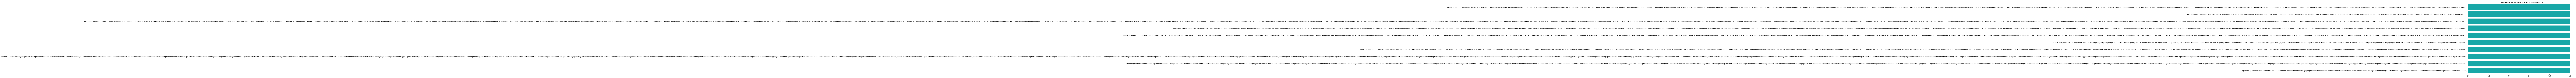

In [48]:
sns.barplot(x=unigrams.values[:10],
            y=unigrams.index[:10],
            orient='h',
            palette=[default_plot_colour]
            ).set(title="most common unigrams after preproceessing")

In [ ]:
bagrams =(pd.Series(nltk.ngrams(tokens_clean , 2)).value_counts())
print(bagrams[:10])

(i, n)    5242
(e, r)    4848
(r, e)    4430
(o, n)    4268
(e, s)    4243
(e, n)    3900
(t, e)    3873
(e, d)    3768
(t, i)    3524
(n, t)    3404
dtype: int64


[Text(0.5, 1.0, 'most common unigrams after preproceessing')]

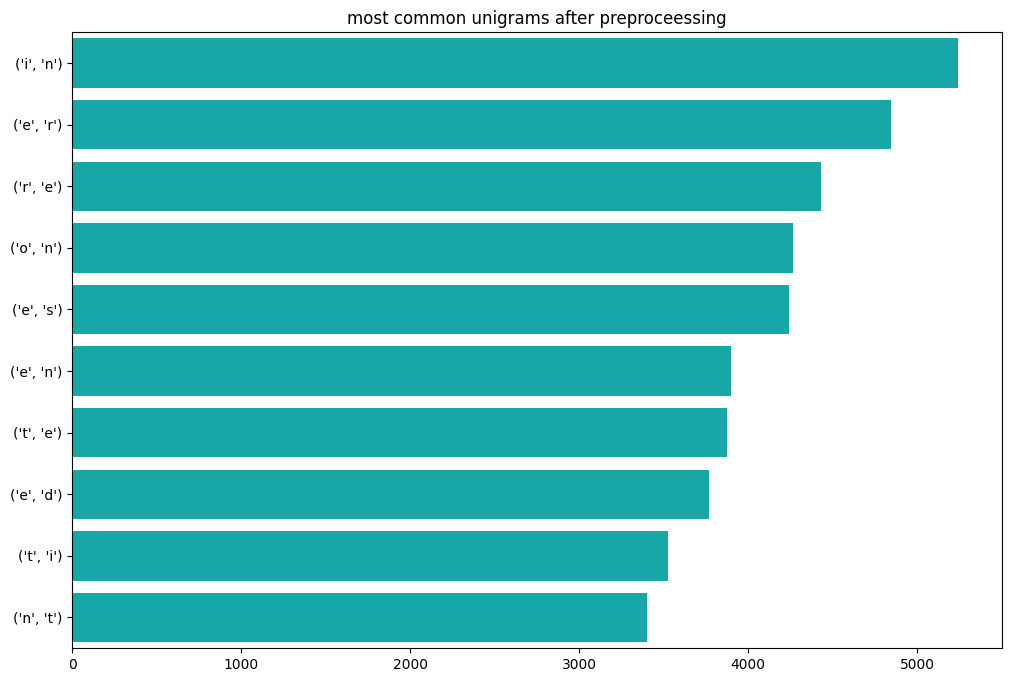

In [ ]:
sns.barplot(x=bagrams.values[:10],
            y=bagrams.index[:10],
            orient='h',
            palette=[default_plot_colour]
            ).set(title="most common unigrams after preproceessing")

# SENTIMENT Analysis

In [49]:
vader_sentiment = SentimentIntensityAnalyzer()

In [50]:
data['vader_sentiment_score']=data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [51]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,[twosmallproblemsanalogysusanjesusmuslimjoseph...,-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,[buriedtrumpbonkersinterviewnewyorktimesreport...,-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,[womenmake50percentcountrygrosslyunderrepresen...,0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,[usdefensesecretaryjimmattissaidmondayrussiabo...,-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,[northernirelandpoliticalpartiesrapidlyrunning...,0.8590


In [52]:
bins = [-1 ,-0.1 , 0.1 , 1]
names=["negative" ,"neutral" ,"positive"]

In [53]:
data['vader_sentiment_label']= pd.cut(data['vader_sentiment_score'],bins,labels=names)

In [54]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,[twosmallproblemsanalogysusanjesusmuslimjoseph...,-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,[buriedtrumpbonkersinterviewnewyorktimesreport...,-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,[womenmake50percentcountrygrosslyunderrepresen...,0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,[usdefensesecretaryjimmattissaidmondayrussiabo...,-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,[northernirelandpoliticalpartiesrapidlyrunning...,0.8590,positive


<Axes: >

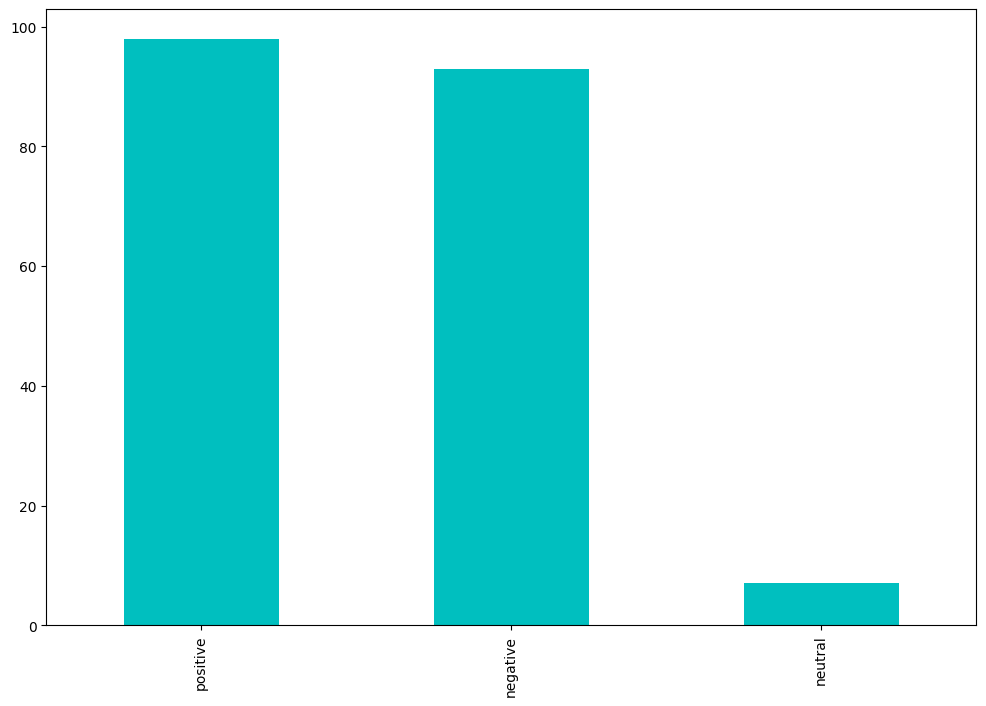

In [55]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)

[Text(0.5, 1.0, 'sentiment by news type')]

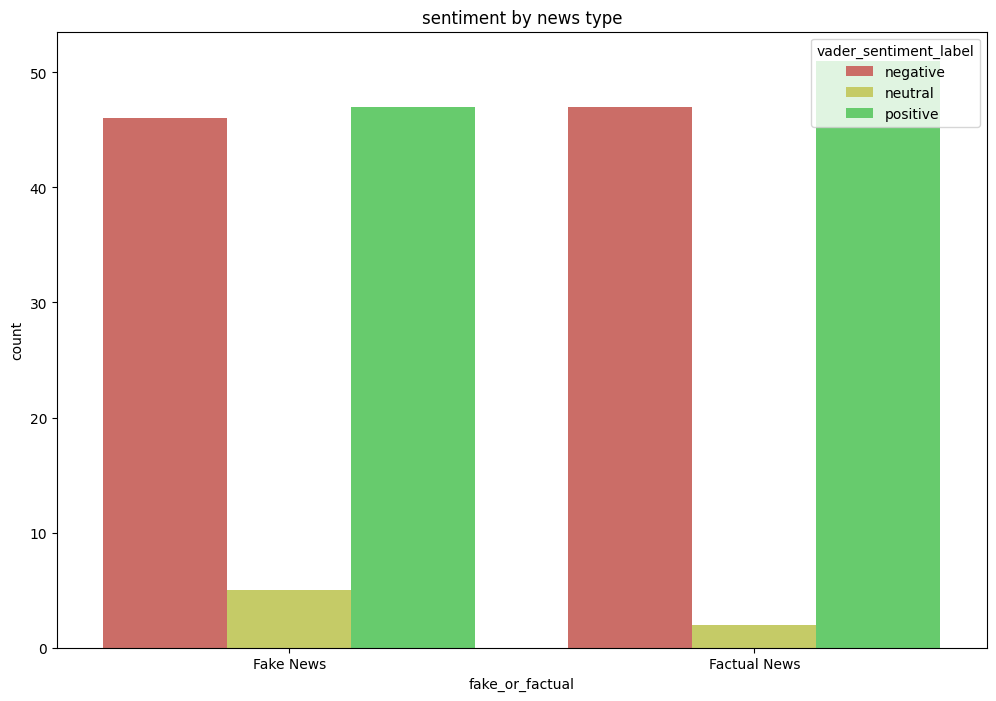

In [56]:
sns.countplot(x= 'fake_or_factual',hue= 'vader_sentiment_label',palette=sns.color_palette("hls"),
              data=data).set(title="sentiment by news type")

[Text(0.5, 1.0, 'sentiment by news type')]

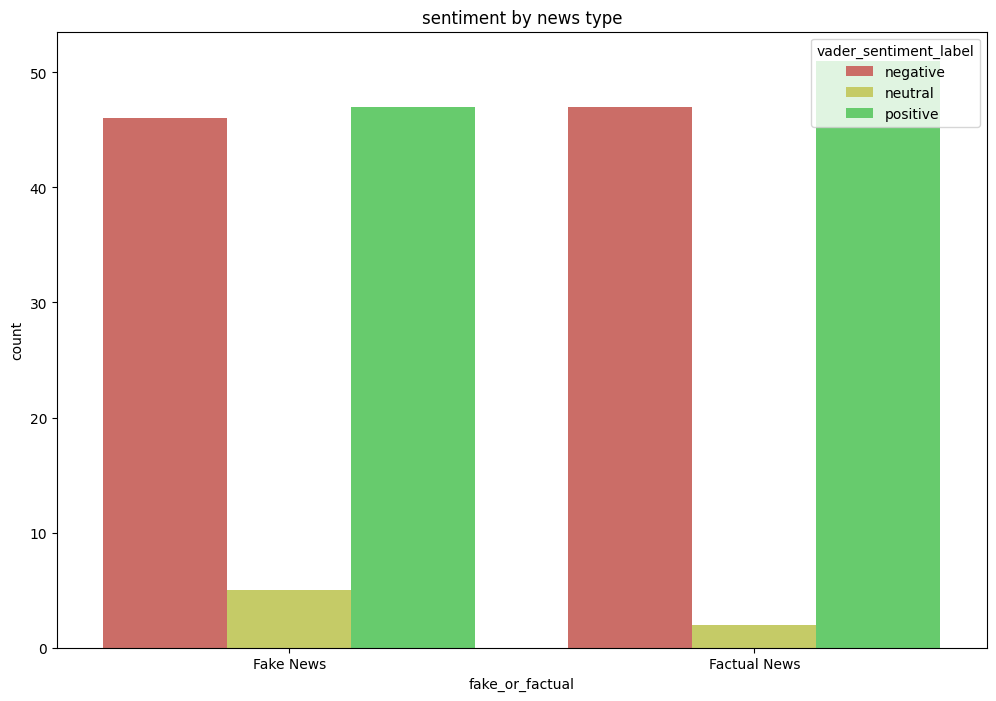

In [57]:
sns.countplot(x= 'fake_or_factual',hue= 'vader_sentiment_label',
              palette=sns.color_palette("hls"),
              data=data).set(title="sentiment by news type")

#Topic Modelling

In [58]:
!pip install gensim

In [81]:
fake_news_text = data[data['fake_or_factual']=="fake news"]['text_clean'].reset_index(drop=True)



In [90]:
dictionary_fake = corpara.Dictionary(fake_news_text)

Dictionary<0 unique tokens: []>


In [85]:
doc_term_fake=[dictionary_fake.doc2bow(text)for text in fake_news_text]

In [92]:
coherence_values =[]

model_list =[]


In [121]:
min_topics =2

max_topics =11

In [128]:
for num_topics_i in range(min_topics ,max_topics+1):
  lda =gensim.models.LdaModel(corpus =doc_term_fake, num_topics=num_topics_i, id2word=dictionary_fake)

#  model__ =gensim.models.LdaModel(corpus=doc_term_fake,id2word=dictionary_fake , num_topics=num_topics_i)
#  model =gensim.models.LdaModel(corpus=doc_term_fake , num_topics=num_topics_i ,id2word =dictionary_fake)
  model_list.append(lda)
  coherence_model =CoherenceModel(model=lda , texts=fake_news_text ,dictionary=dictionary_fake , coherence='c_v')
  coherence_values.append(coherence_model.get_coherence())

In [124]:
plt.plot(range(min_topics , max_topics +1) , coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence scores")
plt.legend(("coherence_value"),loc ="best")
plt.show()

In [128]:
#num_topics_lda = 7
#lda_model =gensim.models.LdaModel(corpus=doc_term_fake , id2word=dictionary_fake,num_topics=num_topics_lda)

In [128]:
num_topics_lda = 7
lda_model =gensim.models.LdaModel(corpus=doc_term_fake , id2word=dictionary_fake,num_topics=num_topics_lda)

In [ ]:
lda_model.print_topics(num_topics_lda ,num_words=10)

#lsimodels

In [143]:
min_topics =2

max_topics =11

In [144]:
def tfidf_corpus(doc_term_matrix):
  tfidf=TfidfModel(corpus=doc_term_matrix , normalize= True)
  corpus_tfidf =tfidf[doc_term_matrix]
  return corpus_tfidf

In [149]:
def get_coherence_scores(corpus ,dictionary ,text ,min_topics ,max_topics):
  coherence_values=[]
  model_lists =[]
  for num_topics_i in range(min_topics , max_topics+1):
    model = LsiModel(corpus ,num_topics=num_topics_i ,id2word=dictionary)
    model_lists.append(model)
    coherence_model =CoherenceModel(model=model ,texts=text ,dictionary=dictionary , coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())


  plt.plot[range(min_topics ,max_topics) ,coherence_values]
  plt.xlabel("number of topics")
  plt.ylabel("coherence score")
  plt.legend(("coherence_values") , loc="best")
plt.show()

In [151]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)
corpus_tfidf_fake

[]

In [151]:
get_coherence_scores(corpus_tfidf_fake , dictionary_fake , fake_news_text ,min_topics ,max_topics+1)

#creating our classifiction model

In [163]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,[twosmallproblemsanalogysusanjesusmuslimjoseph...,-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,[buriedtrumpbonkersinterviewnewyorktimesreport...,-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,[womenmake50percentcountrygrosslyunderrepresen...,0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,[usdefensesecretaryjimmattissaidmondayrussiabo...,-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,[northernirelandpoliticalpartiesrapidlyrunning...,0.8590,positive


In [156]:
X = [','.join(map(str, i)) for i in data['text_clean']]

In [153]:
#X =[','.join(map(str ,data['text_clean']))]


In [157]:
Y =data['fake_or_factual']

In [158]:
countvec = CountVectorizer()

In [159]:
countvec_fit = countvec.fit_transform(X)

In [160]:
bag_of_words =pd.DataFrame(countvec_fit.toarray() , columns=countvec.get_feature_names_out())

In [165]:
x_train ,y_train ,x_test,y_test =train_test_split(bag_of_words ,Y ,test_size=0.3,random_state=42 )

In [166]:
lr = LogisticRegression()

In [172]:
lr_fit = lr.fit(y_train ,x_train)

In [172]:
y_perd_lr =lr.perdict(x_test)


In [ ]:
accuracy_score(y_perd_lr ,y_test)

In [ ]:
print(classification_report(y_test , y_perd_lr))

#SGD_Classifer

In [173]:
svm = SGDClassifier()

In [ ]:
svm_fit= svm.fit(x_train , y_train)

In [ ]:
y_pred_svm = svm_fit.perdict(x_test)

In [ ]:
accuracy_score(y_test , y_pred_svm)

In [ ]:
print(classification_report(y_test , y_pred_svm))